In [1]:
from brian2 import *
import numpy as np

In [2]:
N = 1
v_r = -70*mV # reset voltage
v_th = -55*mV  # threshold voltage
E_l = -90*mV
dia = 20*um
length = 20*um
SA = (2*pi*(dia/2)*length) # units are um2
gL = 1*psiemens/um2 * SA # units are psiemens
C_mem = 10e-6*farad/cm2 * SA # units are farad
E_ex = 0*mV
E_i = -80*mV 
v_c = 0*mV
I_c = 1000*pamp # same as I_ext, units pamp
tau_ge = 200*ms
tau_gi_c = 6.8*ms # units of ms
integ_method = 'heun'
run_time = 100*ms

model_0 = '''
dv/dt = (1/C_mem)*(ge*(v - E_ex) + gi*(v - E_i) + gL*(v - E_l) + I) : volt (unless refractory)
dge/dt = -ge/tau_ge : siemens
dgi/dt = -gi/tau_gi : siemens
I : ampere
tau_gi : second
'''

model_1 = '''
dv/dt = (1/C_mem)*(gL*(v - E_l) + I) : volt (unless refractory)
I : ampere
'''

model_2 = '''
dv/dt = (1/C_mem)*(ge*(v - E_ex) + gL*(v - E_l) + I) : volt (unless refractory)
ge: siemens
I : ampere
'''

In [14]:
# implementing conductance in the synapse equations
# https://brian2.readthedocs.io/en/stable/user/synapses.html?highlight=synapses#summed-variables

G3 = NeuronGroup(N, model_2, threshold='v>v_th', reset='v=v_r', refractory=10*ms, method=integ_method)
G3.I = I_c
G3.ge = 1*psiemens
G3.v = v_c
statemon3 = StateMonitor(G3, variables='v',record=0)

G4 = NeuronGroup(N, model_2, threshold='v>v_th', reset='v=v_r', refractory=10*ms, method=integ_method)
G4.I = I_c
G4.ge = 1*psiemens
G4.v = v_c
statemon4 = StateMonitor(G4, variables='v',record=0)

S3 = Synapses(G3, G4, 
              model ='''w : volt
              dge_syn/dt = -ge_syn/tau_ge : siemens (event-driven)
              ''', on_pre='''v_post += w
              ''',on_post = 'ge_post = ge_syn',delay=50*ms)
S3.connect(i=0, j=0)
# positive weight for an excitatory connection, -ve weight for inhibitory
S3.w = 0.5*volt
S3.ge_syn = 1*psiemens

statemon5 = StateMonitor(S3, variables='ge_syn',record=0)

run(run_time)

WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 4 lines of abstract code, first line is: "_ge_syn := ge_syn * exp(_lio_1 * (- (t - lastupdate))) (constant)"
 [brian2.codegen.generators.base]


Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler


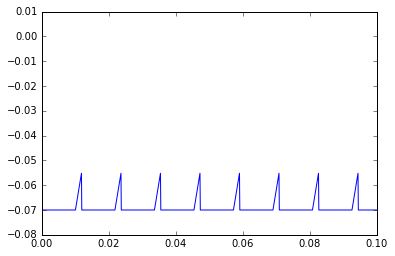

In [15]:
plot(statemon3.t,np.transpose(statemon3.v))

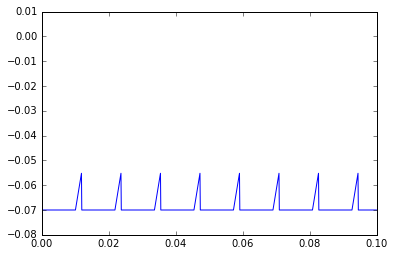

In [16]:
plot(statemon4.t,np.transpose(statemon4.v))

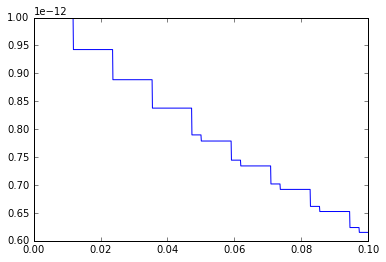

In [17]:
plot(statemon5.t,np.transpose(statemon5.ge_syn))